<a href="https://colab.research.google.com/github/choiboy92/knee_parallax/blob/main/whitesides_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test model setups

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def hip_femur_matrix(angle_val):
  flexion = angle_val[0]*np.pi/180
  var_val = angle_val[1]*np.pi/180
  int_ext = angle_val[2]*np.pi/180
  Rx = np.array([[1, 0, 0],
                [0, np.cos(flexion), -np.sin(flexion)],
                [0, np.sin(flexion), np.cos(flexion)]])
  Ry = np.array([[np.cos(var_val), 0, np.sin(var_val)],
                [0, 1, 0],
                [-np.sin(var_val), 0, np.cos(var_val)]])
  Rz = np.array([[np.cos(int_ext), -np.sin(int_ext), 0],
                [np.sin(int_ext), np.cos(int_ext), 0],
                [0, 0, 1]])
  R = Rx.dot(Ry).dot(Rz)
  return R

def viewing_plane_transform(angle_val):
  flexion = angle_val[0]*np.pi/180
  var_val = (angle_val[1]*np.pi/180) + np.pi
  int_ext = (angle_val[2]*np.pi/180) + np.pi/2

  Rx = np.array([[1, 0, 0],
                [0, np.cos(flexion), -np.sin(flexion)],
                [0, np.sin(flexion), np.cos(flexion)]])
  Ry = np.array([[np.cos(var_val), 0, np.sin(var_val)],
                [0, 1, 0],
                [-np.sin(var_val), 0, np.cos(var_val)]])
  Rz = np.array([[np.cos(int_ext), -np.sin(int_ext), 0],
                [np.sin(int_ext), np.cos(int_ext), 0],
                [0, 0, 1]])
  R = Rx.dot(Ry).dot(Rz)
  return R

In [ ]:
knee_mov = [10, 0, 0]  #flexion, var_val, int_ext
view_mov = [0, 2, 0]  #flexion, var_val, int_ext
femur_length = 45 #cm
view_d = 5 #cm from femur
R = hip_femur_matrix(knee_mov)

origin = np.array([0,0,0])
femur_mx_og = np.array([0,0,-femur_length])  #mechanical axis of femur
femur_mx = np.matmul(R, femur_mx_og)

# Define epicondylar axis & Whitesides points
# Equivalent to drawing of bone references stage
# y-component = 0 as lies in XZ plane
epicondylar = np.array([[4, 0, -femur_length-0.5],
                        [-4, 0, -femur_length+0.5]])
epicondylar[0] = np.matmul(R, epicondylar[0])
epicondylar[1] = np.matmul(R, epicondylar[1])

whiteside = np.array([[0, -1, -femur_length],
                      [-0.3, 7, -femur_length]])
whiteside[0] = np.matmul(R, whiteside[0])
whiteside[1] = np.matmul(R, whiteside[1])

epicondylar_vec = epicondylar[1]- epicondylar[0]
whiteside_vec = whiteside[1]- whiteside[0]
print(epicondylar_vec)
print(whiteside_vec)

# find initial angle in drawing plane between epicondylar axis & Whitesides
theta = np.arccos(np.dot(epicondylar_vec, whiteside_vec)/(np.linalg.norm(epicondylar_vec)*np.linalg.norm(whiteside_vec)))*(180/np.pi)
print("Original angle (deg):", theta)

# define viewing plane position
plane_normal = np.array([0,0, femur_length+view_d])
plane_R = viewing_plane_transform(view_mov)   # transform plane to match optical tracker global coordinates

# get vector of view position to knee
view_pos = np.matmul(plane_R, plane_normal)    # vector of viewing position
view_vec = femur_mx - view_pos
view_normal_unit = view_vec/np.linalg.norm(view_vec)  # unit normal vector

# Find projected vectors of epicondylar axis and Whitesides onto viewing plane
proj_epicondylar = np.cross(view_normal_unit, np.cross(epicondylar_vec, view_normal_unit))
proj_whiteside = np.cross(view_normal_unit, np.cross(whiteside_vec, view_normal_unit))

# Calculate angle between projected vectors
theta_proj = np.arccos(np.dot(proj_epicondylar, proj_whiteside)/(np.linalg.norm(proj_epicondylar)*np.linalg.norm(proj_whiteside)))*(180/np.pi)
print("New angle (deg):", theta_proj)
print("Angle change (deg):", theta_proj- theta)



[-8.         -0.17364818  0.98480775]
[-0.3         7.87846202  1.38918542]
Original angle (deg): 87.86900617209231
New angle (deg): 72.16033815823333
Angle change (deg): -15.708668013858983


## Visualisation sanity plot

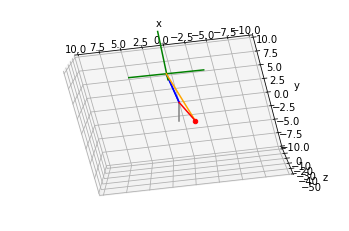

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_zlim(-femur_length-view_d,0)
ax.set_ylim(-10,10)
ax.set_xlim(-10,10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(elev=-80., azim=100)
ax.plot3D([origin[0], femur_mx_og[0]], [origin[1], femur_mx_og[1]], [origin[2], femur_mx_og[2]], 'gray')
ax.plot3D([origin[0], femur_mx[0]], [origin[1], femur_mx[1]], [origin[2], femur_mx[2]], 'blue')
ax.plot3D([origin[0], femur_mx[0]], [origin[1], femur_mx[1]], [origin[2], femur_mx[2]], 'blue')
ax.plot3D(epicondylar[:,0], epicondylar[:,1], epicondylar[:,2], 'green')
ax.plot3D(whiteside[:,0], whiteside[:,1], whiteside[:,2], 'green')
ax.plot3D([view_pos[0], view_pos[0]+ view_vec[0]], [view_pos[1], view_pos[1]+ view_vec[1]], [view_pos[2], view_pos[2]+ view_vec[2]], c='orange')
ax.plot3D([0, view_pos[0]], [0, view_pos[1]], [0, view_pos[2]], c='red')
ax.scatter3D(view_pos[0], view_pos[1], view_pos[2], c='red')

plt.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Scatter3d(x=[origin[0], femur_mx_og[0]], y=[origin[1], femur_mx_og[1]], z=[origin[2], femur_mx_og[2]],
    line=dict(
        color='gray',
        width=2
    ), marker = dict(color = 'rgba(0, 0, 0, 0)')
))
fig.add_scatter3d(x=[origin[0], femur_mx[0]], y=[origin[1], femur_mx[1]], z=[origin[2], femur_mx[2]],
    line=dict(
        color='darkblue',
        width=2
    ), marker = dict(color = 'rgba(0, 0, 0, 0)'))

fig.add_scatter3d(x= [0, view_pos[0]], y=[0, view_pos[1]], z=[0, view_pos[2]],
    line=dict(
        color='red',
        width=2
    ))

fig.add_scatter3d(x=epicondylar[:,0], y=epicondylar[:,1], z=epicondylar[:,2],
    line=dict(
        color='green',
        width=2
    ), marker = dict(color = 'rgba(0, 0, 0, 0)'))

fig.add_scatter3d(x=whiteside[:,0], y=whiteside[:,1], z=whiteside[:,2],
    line=dict(
        color='green',
        width=2
    ), marker = dict(color = 'rgba(0, 0, 0, 0)'))

fig.add_scatter3d(x=[view_pos[0], view_pos[0]+ view_vec[0]], y=[view_pos[1], view_pos[1]+ view_vec[1]], z=[view_pos[2], view_pos[2]+ view_vec[2]],
    line=dict(
        color='orange',
        width=2
    ), marker = dict(color = 'rgba(0, 0, 0, 0)'))

fig.update_scenes(xaxis_range=[-10,10], yaxis_range=[-10,50], zaxis_range=[-femur_length-view_d,0])
fig.show()

# Analysis of Model predictions

In [7]:
# define Whitesides error function
def whiteside_error(knee_mov, view_mov, femur_length, view_d):
  origin = np.array([0,0,0])
  femur_mx_og = np.array([0,0,-femur_length])  #mechanical axis of femur
  angle_diff = []
  for k in range(0, len(knee_mov)):
    R = hip_femur_matrix(knee_mov[k])
    femur_mx = np.matmul(R, femur_mx_og)

    # Define epicondylar axis & Whitesides points
    # Equivalent to drawing of bone references stage
    # y-component = 0 as lies in XZ plane
    epicondylar = np.array([[4, 0, -femur_length-0.5],
                            [-4, 0, -femur_length+0.5]])
    epicondylar[0] = np.matmul(R, epicondylar[0])
    epicondylar[1] = np.matmul(R, epicondylar[1])

    whiteside = np.array([[0, -1, -femur_length],
                          [-0.3, 7, -femur_length]])
    whiteside[0] = np.matmul(R, whiteside[0])
    whiteside[1] = np.matmul(R, whiteside[1])

    epicondylar_vec = epicondylar[1]- epicondylar[0]
    whiteside_vec = whiteside[1]- whiteside[0]
    #print(epicondylar_vec)
    #print(whiteside_vec)

    # find initial angle in drawing plane between epicondylar axis & Whitesides
    theta = np.arccos(np.dot(epicondylar_vec, whiteside_vec)/(np.linalg.norm(epicondylar_vec)*np.linalg.norm(whiteside_vec)))*(180/np.pi)
    #print("Original angle (deg):", theta)

    # define viewing plane position
    plane_normal = np.array([0,0, femur_length+view_d])
    plane_R = viewing_plane_transform(view_mov)   # transform plane to match optical tracker global coordinates

    # get vector of view position to knee
    view_pos = np.matmul(plane_R, plane_normal)    # vector of viewing position
    view_vec = femur_mx - view_pos
    view_normal_unit = view_vec/np.linalg.norm(view_vec)  # unit normal vector

    # Find projected vectors of epicondylar axis and Whitesides onto viewing plane
    proj_epicondylar = np.cross(view_normal_unit, np.cross(epicondylar_vec, view_normal_unit))
    proj_whiteside = np.cross(view_normal_unit, np.cross(whiteside_vec, view_normal_unit))

    # Calculate angle between projected vectors
    theta_proj = np.arccos(np.dot(proj_epicondylar, proj_whiteside)/(np.linalg.norm(proj_epicondylar)*np.linalg.norm(proj_whiteside)))*(180/np.pi)
    #print("New angle (deg):", theta_proj)
    #print("Angle change (deg):", theta_proj- theta)

    angle_diff += [np.abs(theta_proj- theta)]
  return np.array(angle_diff)


132651


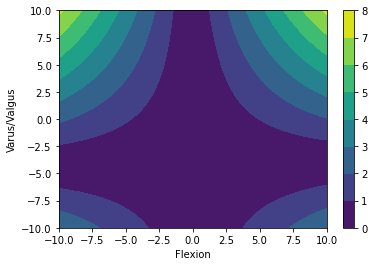

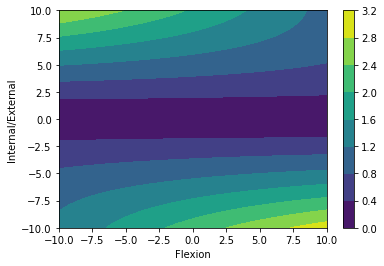

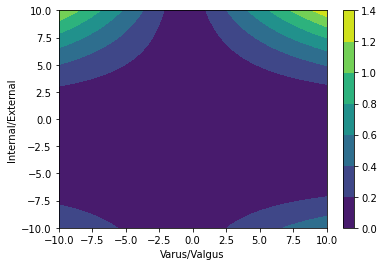

In [46]:
# PLOT FOR COMBINATION VARIATIONS

# generating the meshgrid for plots
num = 51
x1line = np.linspace(-10, 10, num)
x2line = np.linspace(-10, 10, num)
x3line = np.linspace(-10, 10, num)

x1grid, x2grid, x3grid = np.meshgrid(x1line, x2line, x3line)

# produce an grid array with all grid values
Xgrid = np.array([x1grid, x2grid, x3grid]).reshape([3,num*num*num]).T
print(len(Xgrid))

# vary all combinations of angles from -10 to 10 deg
knee_mov = Xgrid  #columns are flexion, var_val, int_ext

# keep viewing plane stationary and perpendicular for now
view_mov = [0, 0, 0]  #flexion, var_val, int_ext
femur_length = 45 #cm
view_d = 65 #cm from hip joint

output = whiteside_error(knee_mov, view_mov, femur_length, view_d)

plot_data = output.reshape(num,num,num)
#print(Xgrid[:num*2])
#print(plot_data)
flex_varvalg = plot_data[:, :, int((num-1)/2)] #x1, x2 varying, fix x3=0
flex_intext = plot_data[int((num-1)/2), :, :]  #x1, x3 varying, fix x2=0
varvalg_intext = plot_data[:, int((num-1)/2), :]  #x2, x3 varying, fix x1=0

plt.contourf(x1line, x2line, flex_varvalg, cmap='viridis')
plt.xlabel("Flexion")
plt.ylabel("Varus/Valgus")
plt.colorbar()
plt.show()

plt.contourf(x1line, x3line, flex_intext, cmap='viridis')
plt.xlabel("Flexion")
plt.ylabel("Internal/External")
plt.colorbar()
plt.show()

plt.contourf(x2line, x3line, varvalg_intext, cmap='viridis')
plt.xlabel("Varus/Valgus")
plt.ylabel("Internal/External")
plt.colorbar()
plt.show()

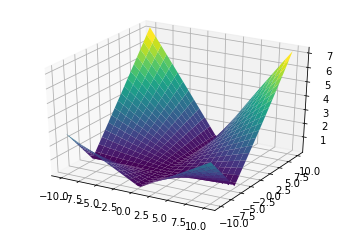

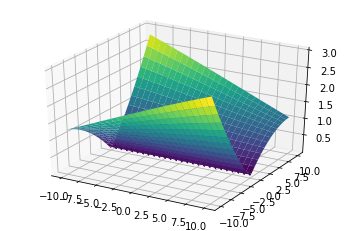

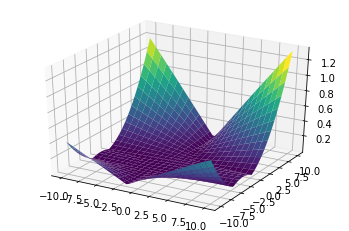

In [47]:
# SURFACE PLOTS
x1_3d, x2_3d  = np.meshgrid(x1line, x2line)
ax = plt.axes(projection='3d')
ax.plot_surface(x1_3d, x2_3d, flex_varvalg, cmap='viridis')
plt.show()

x1_3d, x3_3d  = np.meshgrid(x1line, x3line)
ax = plt.axes(projection='3d')
ax.plot_surface(x1_3d, x3_3d, flex_intext, cmap='viridis')
plt.show()

x2_3d, x3_3d  = np.meshgrid(x2line, x3line)
ax = plt.axes(projection='3d')
ax.plot_surface(x2_3d, x3_3d, varvalg_intext, cmap='viridis')
plt.show()

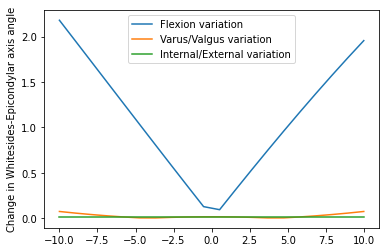

In [48]:
# PLOT OF INDIVIDUAL VARIATIONS
flex_only = np.array([np.linspace(-10,10,20), np.zeros(20),np.zeros(20)]).T
varvalg_only = np.array([np.zeros(20), np.linspace(-10,10,20), np.zeros(20)]).T
intext_only = np.array([np.zeros(20), np.zeros(20), np.linspace(-10,10,20)]).T

plt.plot(flex_only[:,0], whiteside_error(flex_only, view_mov, femur_length, view_d), label="Flexion variation")
plt.plot(varvalg_only[:,1], whiteside_error(varvalg_only, view_mov, femur_length, view_d), label="Varus/Valgus variation")
plt.plot(intext_only[:,2], whiteside_error(intext_only, view_mov, femur_length, view_d), label="Internal/External variation")
#plt.ylim(-0.5, 0.5)
plt.ylabel("Change in Whitesides-Epicondylar axis angle")
plt.legend()
plt.show()

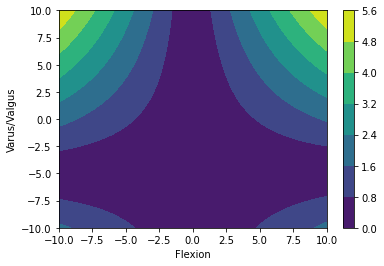

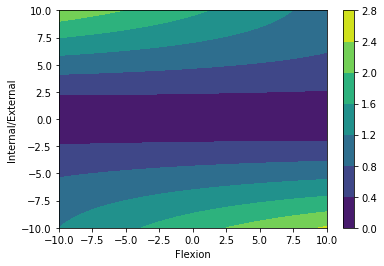

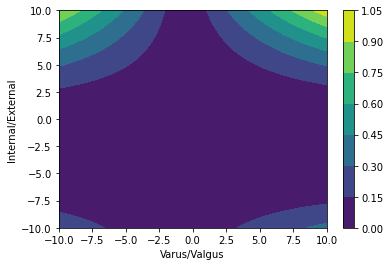

In [49]:
# Change distance from femur

view_d = 105 #cm from hip joint (60 from knee)
num = 51
output = whiteside_error(knee_mov, view_mov, femur_length, view_d)

plot_data = output.reshape(num,num,num)
#print(Xgrid[:num*2])
#print(plot_data)
flex_varvalg = plot_data[:, :, int((num-1)/2)] #x1, x2 varying, fix x3=0
flex_intext = plot_data[int((num-1)/2), :, :]  #x1, x3 varying, fix x2=0
varvalg_intext = plot_data[:, int((num-1)/2), :]  #x2, x3 varying, fix x1=0

plt.contourf(x1line, x2line, flex_varvalg, cmap='viridis')
plt.xlabel("Flexion")
plt.ylabel("Varus/Valgus")
plt.colorbar()
plt.show()

plt.contourf(x1line, x3line, flex_intext, cmap='viridis')
plt.xlabel("Flexion")
plt.ylabel("Internal/External")
plt.colorbar()
plt.show()

plt.contourf(x2line, x3line, varvalg_intext, cmap='viridis')
plt.xlabel("Varus/Valgus")
plt.ylabel("Internal/External")
plt.colorbar()
plt.show()

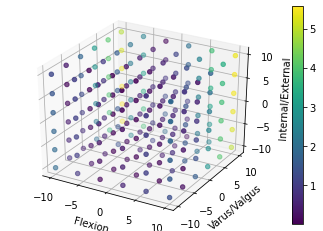

5.566528105751942


In [54]:
# 3D PLOT 
# generating the meshgrid for plots
num = 6
x1line_n = np.linspace(-10, 10, num)
x2line_n = np.linspace(-10, 10, num)
x3line_n = np.linspace(-10, 10, num)

x1grid_n, x2grid_n, x3grid_n = np.meshgrid(x1line_n , x2line_n, x3line_n)

# produce an grid array with all grid values
Xgrid_n = np.array([x1grid_n, x2grid_n, x3grid_n]).reshape([3,num*num*num]).T

fig = plt.figure()
ax = plt.axes(projection='3d')
img = ax.scatter3D(x1grid_n, x2grid_n, x3grid_n, c=whiteside_error(Xgrid_n, view_mov, femur_length, view_d).reshape(num,num,num), cmap='viridis')
ax.set_xlabel("Flexion")
ax.set_ylabel("Varus/Valgus")
ax.set_zlabel("Internal/External")
fig.colorbar(img)
plt.show()

print(np.amax(output))